In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1' 
from time import time
import numpy as np
numSeed = 42
np.random.seed(numSeed)
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import keras
from keras.layers import Input, Dense, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras.datasets import mnist
from keras.optimizers import Adam

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

import sys  
sys.path.append('../')
from util.util import *

Using TensorFlow backend.


## Declare the parameters

In [2]:
numEpochs = 200
sizeBatch = 128
layerDense = [256, 64, 16, 2]
dimEncode = layerDense[-1]
factNoise = 0
actDense = 'relu'
nameOptim = 'adam'
# nameOptim = Adam(0.0002, 0.5)

## Load the datasets

In [3]:
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()
xTrain = xTrain.astype('float32') / 255.
xTest = xTest.astype('float32') / 255.
# xTrain = (xTrain.astype(np.float32) - 127.5) / 127.5
# xTest = (xTest.astype(np.float32) - 127.5) / 127.5
numTrain = len(xTrain)
numTest = len(xTest)
dimInput = np.prod(xTrain.shape[1:])
sizeDigit = xTrain.shape[1]

xTrain = xTrain.reshape(numTrain, dimInput)
xTest = xTest.reshape(numTest, dimInput)
xTrainNoise = addNoise(xTrain, factNoise=factNoise)
xTestNoise = addNoise(xTest, factNoise=factNoise)
print(xTrain.shape)
print(xTest.shape)

(60000, 784)
(10000, 784)


## Construct the encoder and decoder

In [4]:
inputs = Input(shape=(dimInput,))
x = inputs
for numFilt in layerDense[:-1]:
    x = Dense(numFilt)(x)
    x = LeakyReLU()(x)
encode = Dense(dimEncode)(x)
encoder = Model(inputs, encode, name='encoder')

inputLatent = Input(shape=(dimEncode,))
x = inputLatent
for numFilt in layerDense[-2::-1]:
    x = Dense(numFilt)(x)
    x = LeakyReLU()(x)
x = Dense(dimInput, activation='sigmoid')(x)
decoder = Model(inputLatent, x, name='decoder')

encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16)                0         
__________

## Construct the autoencoder

In [5]:
autoencoder = Model(inputs, decoder(encoder(inputs)))
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
encoder (Model)              (None, 2)                 218482    
_________________________________________________________________
decoder (Model)              (None, 784)               219264    
Total params: 437,746
Trainable params: 437,746
Non-trainable params: 0
_________________________________________________________________


## Compile and train

In [6]:
autoencoder.compile(optimizer=nameOptim, 
                    loss='binary_crossentropy')

tic = time()
listLossTrain = []
listLossValid = []
for epoch in range(numEpochs):

    numLoop = int(numTrain/sizeBatch)
    lossTrain = 0
    for b in range(numLoop):
        # Select a random batch of images
        idx = np.random.randint(0, xTrain.shape[0], sizeBatch)
        imgs = xTrain[idx]
        lbl = yTrain[idx]

        # ---------------------
        #  Train Generator
        # ---------------------

        # Train the generator
        autoencoder.train_on_batch(imgs, imgs)
    lossTrain = autoencoder.evaluate(xTrain, autoencoder.predict(xTrain))
    lossValid = autoencoder.evaluate(xTest, autoencoder.predict(xTest))
    listLossTrain.append(lossTrain)
    listLossValid.append(lossValid)
    
    # Plot the progress
    print ("training loss: ", lossTrain, "training loss: ", lossValid)
history = {"loss":listLossTrain, "val_loss":listLossValid}
class History():
    history = history
history = History()

# history = autoencoder.fit(xTrainNoise, xTrain,
#                 epochs=numEpochs,
#                 sizeBatch=sizeBatch,
#                 shuffle=True,
#                 validation_data=(xTest, xTest))
timeTrain = time() - tic

10000/10000 [==============================] - 0s 39us/step
training loss:  0.2159305030345917 training loss:  0.21467665767669677
10000/10000 [==============================] - 0s 34us/step
training loss:  0.20504781316916149 training loss:  0.20554122891426085
10000/10000 [==============================] - 0s 35us/step
training loss:  0.19592732637723287 training loss:  0.1970465784549713
10000/10000 [==============================] - 0s 39us/step
training loss:  0.19517288246154785 training loss:  0.19625015659332276
10000/10000 [==============================] - 0s 36us/step
training loss:  0.18619415521621704 training loss:  0.18707950401306153
10000/10000 [==============================] - 0s 39us/step
training loss:  0.1885209534486135 training loss:  0.18939117498397828
10000/10000 [==============================] - 0s 34us/step
training loss:  0.18771752651532492 training loss:  0.18864111297130584
10000/10000 [==============================] - 0s 37us/step
training loss:  0.1

10000/10000 [==============================] - 0s 36us/step
training loss:  0.17219028352101645 training loss:  0.17241663694381715
10000/10000 [==============================] - 0s 37us/step
training loss:  0.1690184989452362 training loss:  0.16941939754486085
10000/10000 [==============================] - 0s 37us/step
training loss:  0.16904719670613608 training loss:  0.169448308134079
10000/10000 [==============================] - 0s 36us/step
training loss:  0.16849817798137665 training loss:  0.1688860743045807
10000/10000 [==============================] - 0s 41us/step
training loss:  0.16891325573126476 training loss:  0.1693209525346756
10000/10000 [==============================] - 0s 37us/step
training loss:  0.16744363799889883 training loss:  0.16796148176193237
10000/10000 [==============================] - 0s 41us/step
training loss:  0.16917067573865255 training loss:  0.16941858477592467
10000/10000 [==============================] - 0s 35us/step
training loss:  0.167

10000/10000 [==============================] - 0s 38us/step
training loss:  0.16507195104757943 training loss:  0.16504669408798217
10000/10000 [==============================] - 0s 36us/step
training loss:  0.16619339712460834 training loss:  0.16657631735801698
10000/10000 [==============================] - 0s 40us/step
training loss:  0.16523805929025015 training loss:  0.1652630895137787
10000/10000 [==============================] - 0s 39us/step
training loss:  0.1660344894329707 training loss:  0.16629338572025298
10000/10000 [==============================] - 0s 41us/step
training loss:  0.16534104499022165 training loss:  0.1656755511045456
10000/10000 [==============================] - 0s 40us/step
training loss:  0.16647213999430338 training loss:  0.16677763056755066
10000/10000 [==============================] - 0s 36us/step
training loss:  0.16484559825261433 training loss:  0.16507824869155885
10000/10000 [==============================] - 0s 36us/step
training loss:  0.1

10000/10000 [==============================] - 0s 38us/step
training loss:  0.1632100432475408 training loss:  0.16354313802719117
10000/10000 [==============================] - 0s 37us/step
training loss:  0.1644195600748062 training loss:  0.16445384702682495
10000/10000 [==============================] - 0s 42us/step
training loss:  0.1631535607735316 training loss:  0.16328869554996492
10000/10000 [==============================] - 0s 41us/step
training loss:  0.16295154365698497 training loss:  0.16307618079185485
10000/10000 [==============================] - 0s 36us/step
training loss:  0.16327461194197337 training loss:  0.16323874559402465
10000/10000 [==============================] - 0s 36us/step
training loss:  0.16332318824132283 training loss:  0.16358047552108765
10000/10000 [==============================] - 0s 38us/step
training loss:  0.16226977082888286 training loss:  0.1624220046520233
10000/10000 [==============================] - 0s 40us/step
training loss:  0.16

10000/10000 [==============================] - 0s 37us/step
training loss:  0.16280428737004599 training loss:  0.16280572822093964
10000/10000 [==============================] - 0s 36us/step
training loss:  0.1631269106308619 training loss:  0.163360955452919
10000/10000 [==============================] - 0s 36us/step
training loss:  0.16214627277851104 training loss:  0.1623591282606125
10000/10000 [==============================] - 0s 38us/step
training loss:  0.16258953210512797 training loss:  0.1624494954109192
10000/10000 [==============================] - 0s 35us/step
training loss:  0.16281581088701885 training loss:  0.1628643476486206
10000/10000 [==============================] - 0s 36us/step
training loss:  0.1607056476831436 training loss:  0.16073456127643584
10000/10000 [==============================] - 0s 40us/step
training loss:  0.16332285203138988 training loss:  0.1634439566373825
10000/10000 [==============================] - 0s 35us/step
training loss:  0.162492

## Show the historical training progress 

traing consumed: 1410.696649312973 seconds


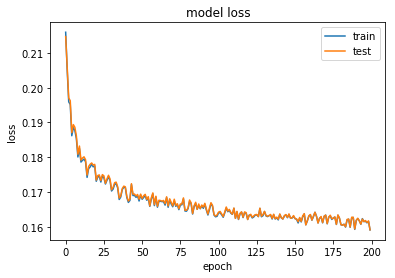

In [7]:
print("traing consumed: " + str(timeTrain) + " seconds")
plotProgress(history)

## Get the encoding and decoding results of testing data, and get the mean/std of the encoding 

In [8]:
# encode and decode some digits
# note that we take them from the *test* set
encodeTest = encoder.predict(xTest)
decodeTest = decoder.predict(encodeTest)
meanEncTest = np.mean(encodeTest, axis=0)
stdEncTest = np.std(encodeTest, axis=0)

In [9]:
oh_loss_real

NameError: name 'oh_loss_real' is not defined

In [10]:
indx = 8
gener = np.zeros([1,10])
gener[:,indx] = 1
print(disOneHot.predict(gener))
decodeTest2 = decoder.predict([[[0, 0.]], gener])
plt.imshow(decodeTest2.reshape(28,28))

NameError: name 'disOneHot' is not defined

## Compare original digitals with the decoding results

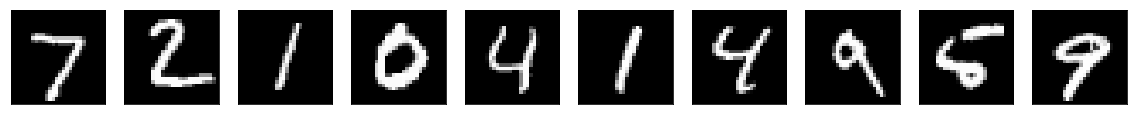

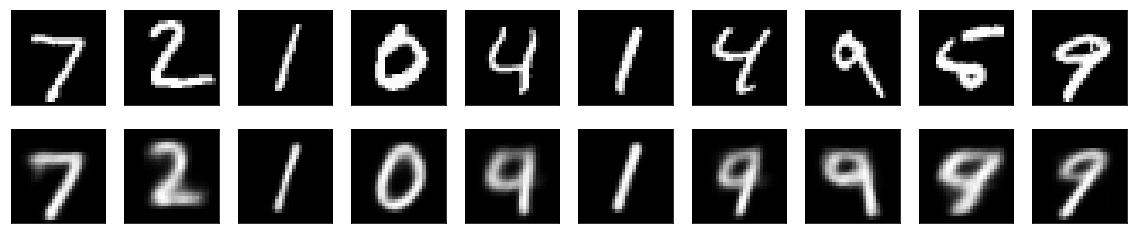

In [11]:
plotCompDecode(xTest, decodeTest, xNoise=xTestNoise)


## Plot the scatter of the encoding space

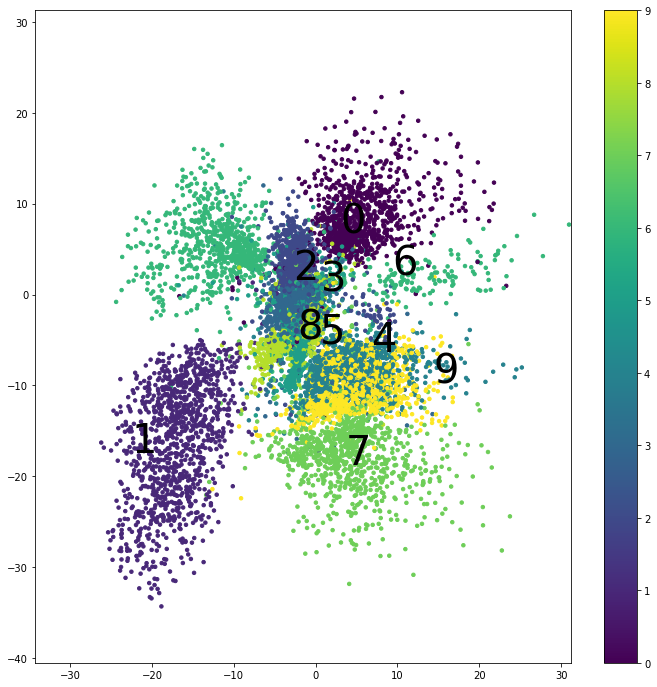

In [12]:
xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])

plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
scoreSilh = silhouette_score(encodeTest, yTest)  

## Plot the decoding results from the encoding scatter 

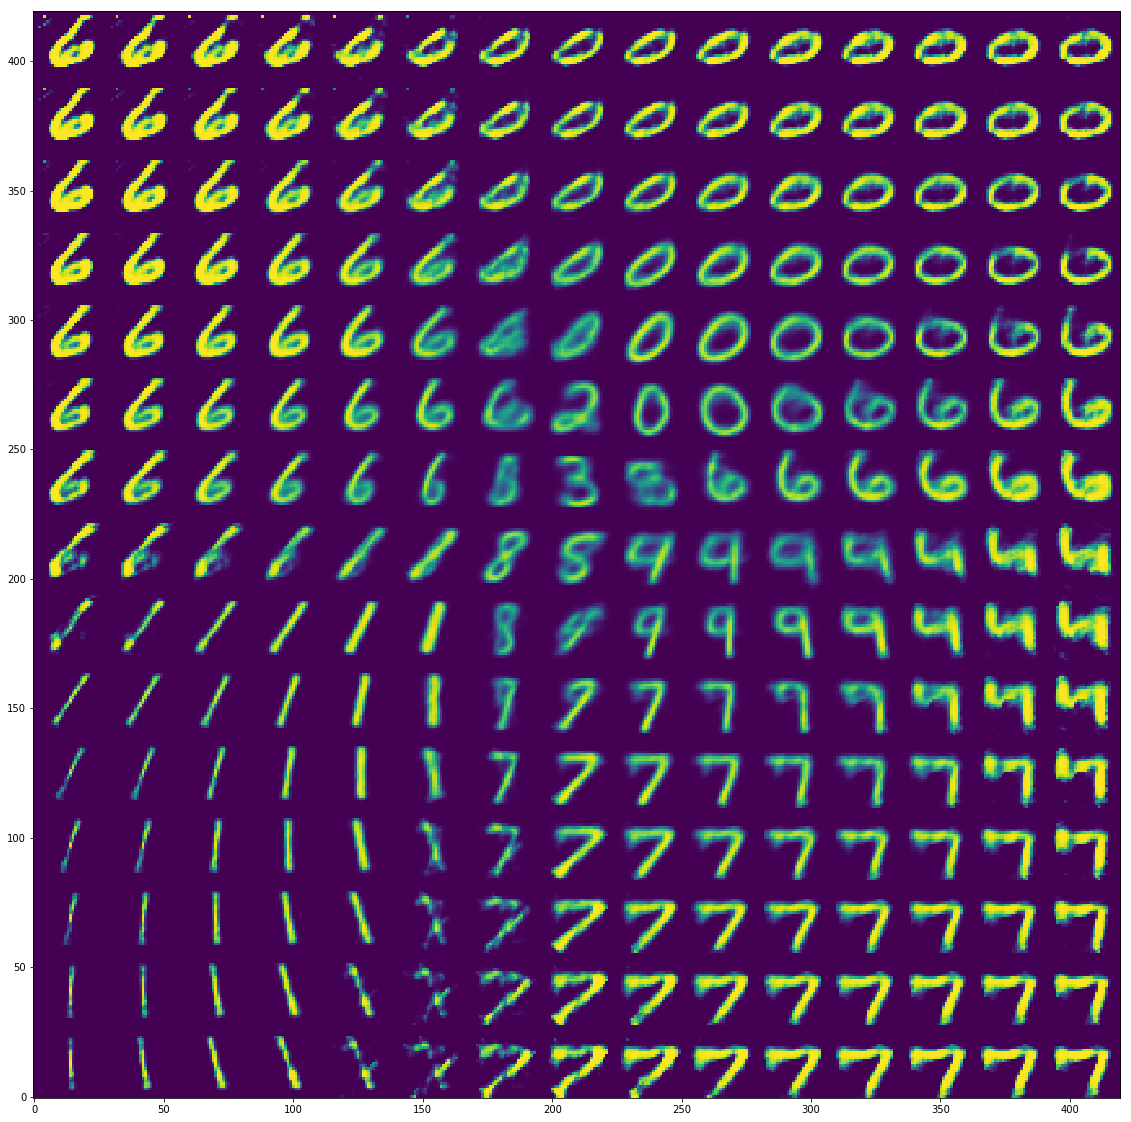

In [13]:
# display a 2D manifold of the digits
plotScatterDecode(decoder, (sizeDigit, sizeDigit), xlim, ylim)

In [ ]:
print(timeTrain, history.history["loss"][numEpochs-1], history.history["val_loss"][numEpochs-1], scoreSilh)

In [ ]:
plt.imshow(decoder.predict([[0, 0], [1,0,0,0,0,0,0,0,0,0]]).reshape(28,28))

In [ ]:
plt.imshow(decoder.predict([encodeTest[0,:], encodeOneHotTest[0,:]]).reshape(28,28))